# Intel Scene Classifier with Augmented Data

**Objective:** Classify the intel scene images with augmented data and compare the accuracy without augmentation.

## Read HDF5 Extracted Features with Augmentation

In [1]:
import h5py

In [2]:
aug_db = h5py.File('./output/IntelSceneAugExtractedFeatures.hdf5')

In [3]:
list(aug_db.keys())

['features', 'labels']

In [4]:
len(aug_db['features'])

600

## Build Model

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [6]:
## params for logistic regression
## C - Regularization parameter
params = { 'C': [0.0001, 0.001, 0.01, 0.1, 1]}

classifier = GridSearchCV(LogisticRegression(), params, cv=3)

In [7]:
classifier.fit(aug_db['features'][ : ], aug_db['labels'][ : ])

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [8]:
print('Best hyperparameter : {}'.format(classifier.best_params_) )

Best hyperparameter : {'C': 0.01}


## Evaluate the Model

## Read the Test Extracted features

Note that for test /validation dataset, don't perform augmentation.

In [9]:
test_db = h5py.File('../output/IntelSceneExtractedFeatures.hdf5')

In [10]:
list(test_db.keys())

['features', 'labels']

In [11]:
len(test_db['features'])

17034

In [12]:
val_start_idx = 100
val_stop_idx  = 125

## Do the Prediction

In [13]:
from sklearn.metrics import classification_report, confusion_matrix

In [14]:
y_actuals = test_db['labels'][val_start_idx:val_stop_idx]
preds = classifier.predict(test_db['features'][val_start_idx:val_stop_idx])

In [15]:
print(classification_report(y_actuals, preds))

              precision    recall  f1-score   support

           0       1.00      0.60      0.75         5
           1       1.00      1.00      1.00         3
           2       0.00      0.00      0.00         1
           3       0.75      0.75      0.75         4
           4       1.00      1.00      1.00         3
           5       0.90      1.00      0.95         9

   micro avg       0.84      0.84      0.84        25
   macro avg       0.78      0.72      0.74        25
weighted avg       0.88      0.84      0.85        25



In [23]:
y_actuals[y_actuals != preds]

array([0, 0, 3, 2])

In [24]:
y_actuals != preds

array([ True,  True, False, False, False, False,  True, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False])

In [28]:
fail_index = [ i  for i in range(0,len(y_actuals)) if y_actuals[i] != preds[i]]

In [29]:
fail_index

[0, 1, 6, 14]

## Visualize the failed cases

In [30]:
import pandas as pd

In [31]:
train_csv_df = pd.read_csv('./dataset/train-scene classification/train.csv')

In [32]:
train_csv_df.head()

,image_name,label
0,0.jpg,0
1,1.jpg,4
2,2.jpg,5
3,4.jpg,0
4,7.jpg,4


## Label distribution

In [82]:
train_csv_df['label'].value_counts()

3    3037
2    2957
5    2883
4    2784
1    2745
0    2628
Name: label, dtype: int64

In [33]:
train_image_names = list(train_csv_df['image_name'])

In [53]:
wrong_predictions = []
fail_df = pd.DataFrame(columns=['image_name', 'orig_label', 'pred'])

for idx in fail_index:
    f_idx = idx + val_start_idx
    img_name = train_image_names[f_idx]
    wrong_predictions.append(img_name)
    fail_df = fail_df.append({ 'image_name': img_name, 
                      'orig_label' : train_csv_df['label'][f_idx], 
                       'pred' : preds[idx]}, ignore_index=True)

     

In [54]:
wrong_predictions

['142.jpg', '146.jpg', '153.jpg', '163.jpg']

In [56]:
fail_df

,image_name,orig_label,pred
0,142.jpg,0,5
1,146.jpg,0,2
2,153.jpg,3,2
3,163.jpg,2,3


In [37]:
class_names = { 0: 'buildings',
               1: 'forest',
               2: 'glacier',
               3: 'mountain',
               4: 'sea',
               5: 'street'
             }

In [57]:
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

In [61]:
failed_imgs = []
for img_name in fail_df['image_name']:
    file_loc = './dataset/train-scene classification/train/' + img_name
    print(file_loc)
    img = cv2.imread(file_loc)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    failed_imgs.append(img)

./dataset/train-scene classification/train/142.jpg
./dataset/train-scene classification/train/146.jpg
./dataset/train-scene classification/train/153.jpg
./dataset/train-scene classification/train/163.jpg


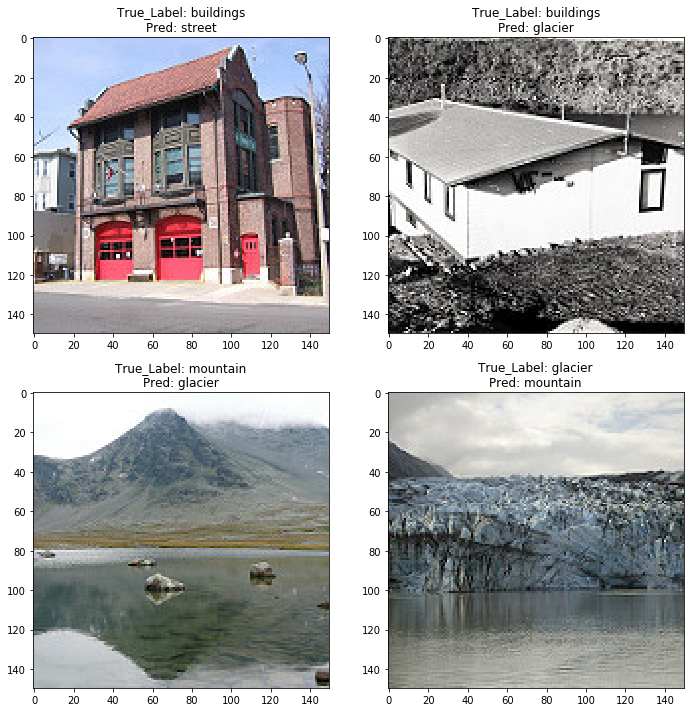

In [68]:
fig, axes = plt.subplots(2,2, figsize=(10,10))
for i in range(0,2):
    for j in range(0,2):
        axes[i,j].imshow(failed_imgs[i*2+j])
        
        true_label = 'True_Label: ' + class_names[fail_df['orig_label'][i*2+j]]
        pred       = 'Pred: ' + class_names[fail_df['pred'][i*2+j]]
        axes[i,j].set_title(true_label + '\n' + pred)
        
plt.tight_layout()
plt.show()

In [75]:
white_building = failed_imgs[1]

In [76]:
white_building_norm = white_building / 255.0

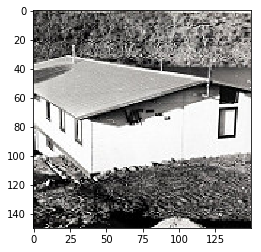

In [77]:
plt.imshow(white_building_norm)
plt.show()